In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import scipy.spatial
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image


from flygym.arena.mujoco_arena import (
    FlatTerrain,
    GappedTerrain,
    BlocksTerrain,
    MixedTerrain,
)
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs
import flygym.util.vision as vision
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb
from flygym.util.config import num_ommatidia_per_eye

In [4]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [69]:
class ObstacleOdorArena(BaseArena):
    num_sensors = 4

    def __init__(
        self,
        terrain: BaseArena,
        obstacle_positions: np.ndarray = np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
        obstacle_colors: Union[np.ndarray, Tuple] = (0, 0, 0, 1),
        obstacle_radius: float = 1,
        obstacle_height: float = 4,
        odor_source: np.ndarray = np.array([[25, 0, 2]]),
        peak_intensity: np.ndarray = np.array([[1]]),
        diffuse_func: Callable = lambda x: x**-2,
        marker_colors: Optional[List[Tuple[float, float, float, float]]] = None,
        marker_size: float = 0.1,
        user_camera_settings: Optional[
            Tuple[Tuple[float, float, float], Tuple[float, float, float], float]
        ] = None,
    ):
        self.terrain_arena = terrain
        self.root_element = terrain.root_element
        self.friction = terrain.friction
        z_offset = terrain.get_spawn_position(np.zeros(3), np.zeros(3))[0][2]
        obstacle_colors = np.array(obstacle_colors)
        if obstacle_colors.shape == (4,):
            obstacle_colors = np.array(
                [obstacle_colors for _ in range(obstacle_positions.shape[0])]
            )
        else:
            assert obstacle_colors.shape == (obstacle_positions.shape[0], 4)

        self.odor_source = np.array(odor_source)
        self.peak_odor_intensity = np.array(peak_intensity)
        self.num_odor_sources = self.odor_source.shape[0]
        if self.odor_source.shape[0] != self.peak_odor_intensity.shape[0]:
            raise ValueError(
                "Number of odor source locations and peak intensities must match."
            )
        self.odor_dim = self.peak_odor_intensity.shape[1]
        self.diffuse_func = diffuse_func

        # Add markers at the odor sources
        if marker_colors is None:
            marker_colors = []
            num_odor_sources = self.odor_source.shape[0]
            for i in range(num_odor_sources):
                rgb = np.array(color_cycle_rgb[i % num_odor_sources]) / 255
                rgba = (*rgb, 1)
                marker_colors.append(rgba)
        for i, (pos, rgba) in enumerate(zip(self.odor_source, marker_colors)):
            pos = list(pos)
            pos[2] += z_offset
            marker_body = self.root_element.worldbody.add(
                "body", name=f"odor_source_marker_{i}", pos=pos, mocap=True
            )
            marker_body.add(
                "geom", type="capsule", size=(marker_size, marker_size), rgba=rgba
            )

        # Reshape odor source and peak intensity arrays to simplify future claculations
        _odor_source_repeated = self.odor_source[:, np.newaxis, np.newaxis, :]
        _odor_source_repeated = np.repeat(_odor_source_repeated, self.odor_dim, axis=1)
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.num_sensors, axis=2
        )
        self._odor_source_repeated = _odor_source_repeated
        _peak_intensity_repeated = self.peak_odor_intensity[:, :, np.newaxis]
        _peak_intensity_repeated = np.repeat(
            _peak_intensity_repeated, self.num_sensors, axis=2
        )
        self._peak_intensity_repeated = _peak_intensity_repeated

        # Add obstacles
        self.obstacle_bodies = []
        obstacle_material = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.obstacle_z_pos = z_offset + obstacle_height / 2
        for i in range(obstacle_positions.shape[0]):
            obstacle_pos = [*obstacle_positions[i, :], self.obstacle_z_pos]
            obstacle_color = obstacle_colors[i]
            obstacle_body = self.root_element.worldbody.add(
                "body", name=f"obstacle_{i}", mocap=True, pos=obstacle_pos
            )
            self.obstacle_bodies.append(obstacle_body)
            obstacle_body.add(
                "geom",
                type="cylinder",
                size=(obstacle_radius, obstacle_height / 2),
                rgba=obstacle_color,
                material=obstacle_material,
            )

        # Add monitor cameras
        self.root_element.worldbody.add(
            "camera",
            name="side_cam",
            mode="fixed",
            pos=(12.5, -25, 10),
            euler=(np.deg2rad(75), 0, 0),
            fovy=50,
        )
        self.root_element.worldbody.add(
            "camera",
            name="back_cam",
            mode="fixed",
            pos=(-10, 0, 12),
            euler=(0, np.deg2rad(-60), -np.deg2rad(90)),
            fovy=50,
        )
        self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(0, 0, 40),
            euler=(0, 0, 0),
            fovy=50,
        )
        if user_camera_settings is not None:
            cam_pos, cam_euler, cam_fovy = user_camera_settings
            self.root_element.worldbody.add(
                "camera",
                name="user_cam",
                mode="fixed",
                pos=cam_pos,
                euler=cam_euler,
                fovy=cam_fovy,
            )

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return self.terrain_arena.get_spawn_position(rel_pos, rel_angle)

    def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        antennae_pos_repeated = antennae_pos[np.newaxis, np.newaxis, :, :]
        dist_3d = antennae_pos_repeated - self._odor_source_repeated  # (n, k, w, 3)
        dist_euc = np.linalg.norm(dist_3d, axis=3)  # (n, k, w)
        scaling = self.diffuse_func(dist_euc)  # (n, k, w)
        intensity = self._peak_intensity_repeated * scaling  # (n, k, w)
        return intensity.sum(axis=0)  # (k, w)

In [71]:
def sample_visual_data(
    nmf, obstacle_positions, action, visualize=False, camera="birdeye_cam"
):
    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], nmf.arena.obstacle_z_pos])
        nmf.physics.bind(nmf.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
        nmf.step(action)

    # Render visual input
    nmf._last_vision_update_time = -np.inf  # hack: this forces visual input update
    nmf._update_vision()
    visual_input = nmf.curr_visual_input.copy()
    raw_cam_imgs = nmf.curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    assert np.allclose(nmf.spawn_orient[:3], [0, 0, 1])
    fly_rotation = nmf.spawn_orient[3]
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - nmf.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = nmf.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=255)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = vision.hex_pxls_to_human_readable(
                visual_input[i], vision.ommatidia_id_map
            )
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=255)
            axs[i + 3].axis("off")

    return visual_input, obstacle_positions_transformed

In [1]:
terrain_arena = GappedTerrain(
    x_range=(-20, 40), y_range=(-20, 20), gap_width=0.2, ground_alpha=1
)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5), (-10, -10)]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
    user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
)
sim_params = MuJoCoParameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(12, -4, 0.5),
    spawn_orient=(0, 0, 1, np.deg2rad(20)),
)
action = {"joints": data_block[:, 0]}
for i in range(100):
    nmf.step(action)
    nmf.render()

plt.imshow(nmf._frames[-1])
Image.fromarray(nmf._frames[-1]).save("outputs/env_schematic.png")

NameError: name 'GappedTerrain' is not defined

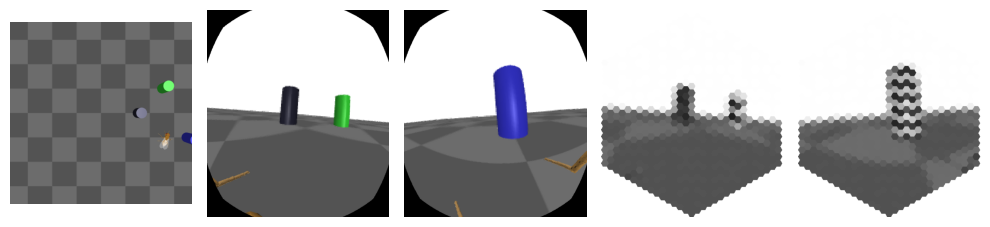

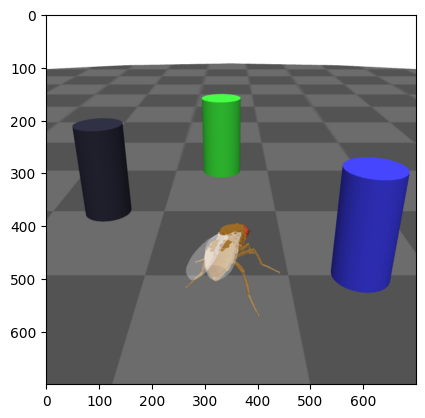

In [83]:
terrain_arena = FlatTerrain()
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.01,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)
sim_params = MuJoCoParameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(13, -5, 0.5),
    spawn_orient=(0, 0, 1, np.deg2rad(70)),
)
action = {"joints": data_block[:, 0]}
for i in range(100):
    nmf.step(action)
    nmf.render()

sample_visual_data(
    nmf, np.array([(7.5, 0), (12.5, 5), (17.5, -5)]), action, visualize=True
)
plt.savefig("outputs/visual_input.pdf")
plt.show()

env_viz = nmf.physics.render(camera_id="user_cam", height=700, width=700)

plt.imshow(env_viz)
Image.fromarray(env_viz).save("outputs/visual_input_env.png")

In [42]:
max_num_obstacles = 6
num_fly_states_per_num_obstacle = 50
obstacle_states_per_fly_state = 100
fly_pos_range = (-5, 5)
fly_rotation_range = (-np.pi, np.pi)
obstacle_pos_range = (-10, 10)
min_obstacle_dist = 4

all_rows = []
for num_obstacles in range(max_num_obstacles):
    for terrain_name in ["flat", "gapped"]:
        print(
            f"Generating data for {num_obstacles} obstacles, {terrain_name} terrain..."
        )

        # Sample fly states
        for i in trange(num_fly_states_per_num_obstacle):

            # Initialize fly. Retry with different fly position/pose if needed.
            while True:
                try:
                    # Create arena
                    if terrain_name == "flat":
                        terrain_arena = FlatTerrain()
                    elif terrain_name == "gapped":
                        terrain_arena = GappedTerrain(
                            x_range=(-30, 30), y_range=(-30, 30), gap_width=0.2
                        )
                    else:
                        raise ValueError(f"Unknown terrain name: {terrain_name}")
                    _xy_pos = np.arange(*obstacle_pos_range, min_obstacle_dist)
                    init_obstacle_positions = np.vstack([_xy_pos, _xy_pos]).T
                    arena = ObstacleOdorArena(
                        terrain=terrain_arena,
                        obstacle_positions=init_obstacle_positions[:num_obstacles, :],
                        marker_size=0.5,
                        obstacle_colors=(0.14, 0.14, 0.2, 1),
                    )
                    
                    sim_params = MuJoCoParameters(
                        render_playspeed=0.2,
                        render_camera="fly_centered_birdeye_cam",
                        enable_vision=True,
                        render_raw_vision=True,
                        enable_olfaction=True,
                    )
                    fly_pos = np.random.uniform(
                        low=fly_pos_range[0], high=fly_pos_range[1], size=(2)
                    )
                    fly_rotation = np.random.uniform(
                        low=fly_rotation_range[0], high=fly_rotation_range[1]
                    )
                    nmf = NeuroMechFlyMuJoCo(
                        sim_params=sim_params,
                        arena=arena,
                        spawn_pos=(*fly_pos, 0.5),
                        spawn_orient=(0, 0, 1, fly_rotation),
                    )
                    
                    action = {
                        "joints": data_block[:, np.random.randint(data_block.shape[1])]
                    }
                    for i in range(100):
                        nmf.step(action)
                        nmf.render()
                    break
                except PhysicsError:
                    print("Physics error, trying again with different pose...")

            # Shuffle obstacle positions a bunch of times and save visual data
            for j in range(1 if num_obstacles == 0 else                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        obstacle_states_per_fly_state):
                while True:
                    obstacle_positions = np.random.uniform(
                        low=obstacle_pos_range[0],
                        high=obstacle_pos_range[1],
                        size=(num_obstacles, 2),
                    )
                    if num_obstacles > 1:
                        dists = scipy.spatial.distance.pdist(obstacle_positions)
                        if dists.min() >= min_obstacle_dist:
                            break
                    else:
                        break
                visual_input, rel_positions = sample_visual_data(
                    nmf, obstacle_positions, action, visualize=False
                )
                visual_input = visual_input.sum(axis=-1)
                label = np.full((max_num_obstacles, 2), np.nan)
                label[:num_obstacles, :] = rel_positions
                row = [
                    num_obstacles,
                    terrain_name,
                    i,
                    j,
                    *label.flatten(),
                    *visual_input.flatten(),
                ]
                all_rows.append(row)

Generating data for 0 obstacles, flat terrain...


  2%|▏         | 1/50 [00:04<03:41,  4.53s/it]


KeyboardInterrupt: 

In [8]:
columns = ["num_obstacles", "terrain_name", "fly_state_idx", "obstacle_state_idx"]
columns += [
    f"obstacle_{i}_{coord}" for i in range(max_num_obstacles) for coord in ["x", "y"]
]
columns += [
    f"visual_input_{side}_{i}"
    for side in ["left", "right"]
    for i in range(num_ommatidia_per_eye)
]
df = pd.DataFrame(all_rows, columns=columns)
df.to_pickle("data/visual_samples.pkl")

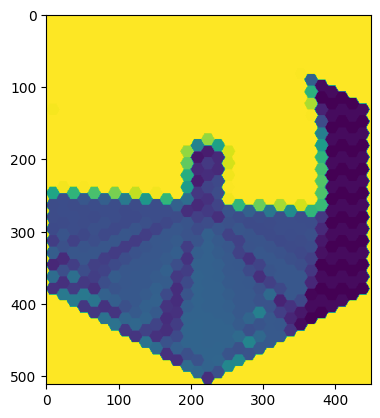

In [9]:
visual_input = df.iloc[-5][[f"visual_input_left_{i}" for i in range(num_ommatidia_per_eye)]].values.astype(np.float32)
visual_input = np.repeat(visual_input[:, np.newaxis], 3, axis=1)
plt.imshow(vision.hex_pxls_to_human_readable(visual_input, vision.ommatidia_id_map))

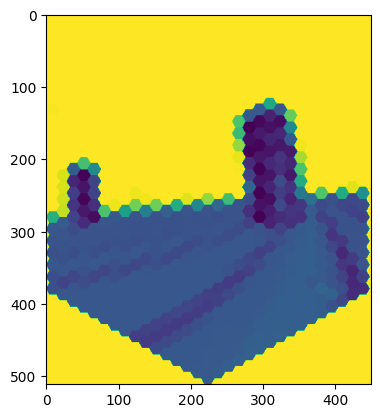

In [10]:
visual_input = df.iloc[-5][[f"visual_input_right_{i}" for i in range(num_ommatidia_per_eye)]].values.astype(np.float32)
visual_input = np.repeat(visual_input[:, np.newaxis], 3, axis=1)
plt.imshow(vision.hex_pxls_to_human_readable(visual_input, vision.ommatidia_id_map))

In [11]:
df.iloc[-5]["obstacle_3_x"]

11.156376785863909